Train set: 10 queries
w_dense=0.00 → Mean Recall@10=0.000
w_dense=0.10 → Mean Recall@10=0.000
w_dense=0.20 → Mean Recall@10=0.000
w_dense=0.30 → Mean Recall@10=0.000
w_dense=0.40 → Mean Recall@10=0.000
w_dense=0.50 → Mean Recall@10=0.000
w_dense=0.60 → Mean Recall@10=0.000
w_dense=0.70 → Mean Recall@10=0.000
w_dense=0.80 → Mean Recall@10=0.000
w_dense=0.90 → Mean Recall@10=0.000
w_dense=1.00 → Mean Recall@10=0.000
w_dense=0.00 → Mean Recall@10=0.000
w_dense=0.10 → Mean Recall@10=0.000
w_dense=0.20 → Mean Recall@10=0.000
w_dense=0.30 → Mean Recall@10=0.000
w_dense=0.40 → Mean Recall@10=0.000
w_dense=0.50 → Mean Recall@10=0.000
w_dense=0.60 → Mean Recall@10=0.000
w_dense=0.70 → Mean Recall@10=0.000
w_dense=0.80 → Mean Recall@10=0.000
w_dense=0.90 → Mean Recall@10=0.000
w_dense=1.00 → Mean Recall@10=0.000


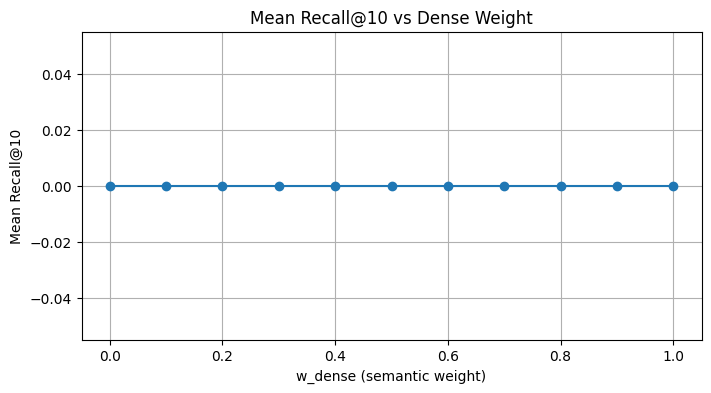


✅ Best weights → w_dense=0.00, w_sparse=1.00, Mean Recall@10=0.000
Updated backend/config.py with best weights.


In [ ]:
# notebooks/03_eval_recall.ipynb (convertible to .py)

"""
Evaluates hybrid recommender performance on labeled Train-Set.
Computes Recall@10 and tunes w_dense / w_sparse.
"""

import pandas as pd
import numpy as np
import faiss
import pickle
import nltk
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

nltk.download('punkt', quiet=True)

# ----------------------------
# Load all artifacts
# ----------------------------
train_df = pd.read_excel('../data/Gen_AI Dataset.xlsx', sheet_name='Train-Set')
train_df.columns = [c.strip() for c in train_df.columns]
CATALOG_PATH = '../data/catalog_clean.csv'

catalog = pd.read_csv(CATALOG_PATH)
index = faiss.read_index('../data/embeddings.faiss')
model = SentenceTransformer('all-MiniLM-L6-v2')
with open('../data/bm25.pkl', 'rb') as f:
    bm25 = pickle.load(f)

print(f"Train set: {train_df['Query'].nunique()} queries")

# Group ground-truth URLs per query
truth_map = train_df.groupby('Query')['Assessment_url'].apply(set).to_dict()

# ----------------------------
# Hybrid search helper
# ----------------------------

def hybrid_search(query, top_k=10, w_dense=0.55, w_sparse=0.45):
    q_tokens = nltk.word_tokenize(query.lower())
    sparse_scores = np.array(bm25.get_scores(q_tokens))

    q_emb = model.encode([query], convert_to_numpy=True)
    faiss.normalize_L2(q_emb)
    dense_scores, _ = index.search(q_emb, len(catalog))
    dense_scores = dense_scores.flatten()

    final_scores = w_dense * dense_scores + w_sparse * sparse_scores
    top_ids = np.argsort(final_scores)[::-1][:top_k]
    return catalog.iloc[top_ids]['url'].tolist()

# ----------------------------
# Recall@K computation
# ----------------------------

import re

def normalize(url: str):
    """Normalize SHL URLs to get the last meaningful slug (after /view/)."""
    if not isinstance(url, str):
        return ""
    # Extract substring after /view/
    match = re.search(r'/view/([^/]+)/?', url.lower())
    if match:
        slug = match.group(1)
    else:
        slug = url.strip('/').split('/')[-1].lower()
    # Clean up any '(new)' or punctuation
    slug = re.sub(r'\(.*?\)', '', slug)
    slug = slug.replace('-', '').replace('_', '')
    return slug.strip()


def recall_at_k(preds, truth, k=10):
    """Compute Recall@K using normalized URL slugs."""
    if not truth:
        return 0.0
    preds_k = preds[:k]
    truth_norm = {normalize(u) for u in truth}
    preds_norm = [normalize(p) for p in preds_k]
    hits = len(set(preds_norm) & truth_norm)
    return hits / len(truth_norm)

# Now rerun the evaluation loop
weights = np.linspace(0, 1, 11)
results = []

for w_dense in weights:
    w_sparse = 1 - w_dense
    recalls = []
    for q, truth in truth_map.items():
        preds = hybrid_search(q, top_k=10, w_dense=w_dense, w_sparse=w_sparse)
        r = recall_at_k(preds, truth, k=10)
        recalls.append(r)
    mean_r = np.mean(recalls)
    results.append({'w_dense': w_dense, 'w_sparse': w_sparse, 'mean_recall@10': mean_r})
    print(f"w_dense={w_dense:.2f} → Mean Recall@10={mean_r:.3f}")

res_df = pd.DataFrame(results)


# ----------------------------
# Evaluate recall over grid search
# ----------------------------

weights = np.linspace(0, 1, 11)
results = []

for w_dense in weights:
    w_sparse = 1 - w_dense
    recalls = []
    for q, truth in truth_map.items():
        preds = hybrid_search(q, top_k=10, w_dense=w_dense, w_sparse=w_sparse)
        r = recall_at_k(preds, truth, k=10)
        recalls.append(r)
    mean_r = np.mean(recalls)
    results.append({'w_dense': w_dense, 'w_sparse': w_sparse, 'mean_recall@10': mean_r})
    print(f"w_dense={w_dense:.2f} → Mean Recall@10={mean_r:.3f}")

res_df = pd.DataFrame(results)

# Plot results
plt.figure(figsize=(8,4))
plt.plot(res_df['w_dense'], res_df['mean_recall@10'], marker='o')
plt.title('Mean Recall@10 vs Dense Weight')
plt.xlabel('w_dense (semantic weight)')
plt.ylabel('Mean Recall@10')
plt.grid(True)
plt.savefig('../data/recall_tuning.png', dpi=200)
plt.show()

best_row = res_df.loc[res_df['mean_recall@10'].idxmax()]
print(f"\n Best weights → w_dense={best_row['w_dense']:.2f}, w_sparse={best_row['w_sparse']:.2f}, Mean Recall@10={best_row['mean_recall@10']:.3f}")

# Save to config file for backend use
with open('../backend/config.py', 'w') as f:
    f.write(f"W_DENSE = {best_row['w_dense']:.2f}\nW_SPARSE = {best_row['w_sparse']:.2f}\n")

print("Updated backend/config.py with best weights.")

In [11]:
for q, truth in list(truth_map.items())[:3]:
    preds = hybrid_search(q, top_k=10)
    truth_norm = {normalize(t) for t in truth}
    preds_norm = [normalize(p) for p in preds]
    print(q[:50], "→ hits:", set(preds_norm) & truth_norm)


Based on the JD below recommend me assessment for  → hits: set()
Content Writer required, expert in English and SEO → hits: set()
Find me 1 hour long assesment for the below job at → hits: set()


In [12]:
import pandas as pd

df = pd.read_csv('../data/catalog_clean.csv')
print(df['name'].tolist())


['Account Manager Solution', 'Administrative Professional - Short Form', 'Agency Manager Solution', 'Apprentice + 8.0 Job Focused Assessment', 'Apprentice 8.0 Job Focused Assessment', 'Bank Administrative Assistant - Short Form', 'Bank Collections Agent - Short Form', 'Bank Operations Supervisor - Short Form', 'Bilingual Spanish Reservation Agent Solution', 'Bookkeeping, Accounting, Auditing Clerk Short Form', 'Branch Manager - Short Form', 'Cashier Solution', 'Global Skills Development Report', '.NET Framework 4.5', '.NET MVC (New)', '.NET MVVM (New)', '.NET WCF (New)', '.NET WPF (New)', '.NET XAML (New)', 'Accounts Payable (New)', 'Accounts Payable Simulation (New)', 'Accounts Receivable (New)', 'Accounts Receivable Simulation (New)', 'ADO.NET (New)']


In [ ]:
import pandas as pd
df = pd.read_csv("D:\projects\shl-recommender\data\submission.csv")
print(df.head(20))
print("Unique queries:", df["Query"].nunique())
print("Total rows:", len(df))


FileNotFoundError: [Errno 2] No such file or directory: '/data/submission.csv'